In [31]:
QUERIES = ["20", "50"]


In [32]:
import os
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split


def create_dataframe_from_directories(path):
    data = []

    for label_dir in os.listdir(path):
        if os.path.isfile(label_dir):
            continue

        label_path_path = os.path.join(path, label_dir)
        for file in os.listdir(label_path_path):
            data.append([os.path.join(label_path_path, file), label_dir])
        
    return pd.DataFrame(data, columns = ["path", "label"])

In [33]:
df = create_dataframe_from_directories("data")
labels = df['label']
df.head()


path label
0  data\20\IMG_6051.JPG    20
1  data\20\IMG_6052.JPG    20
2  data\20\IMG_6053.JPG    20
3  data\20\IMG_6054.JPG    20
4  data\20\IMG_6055.JPG    20

**TODO**: Display some images of your dataset

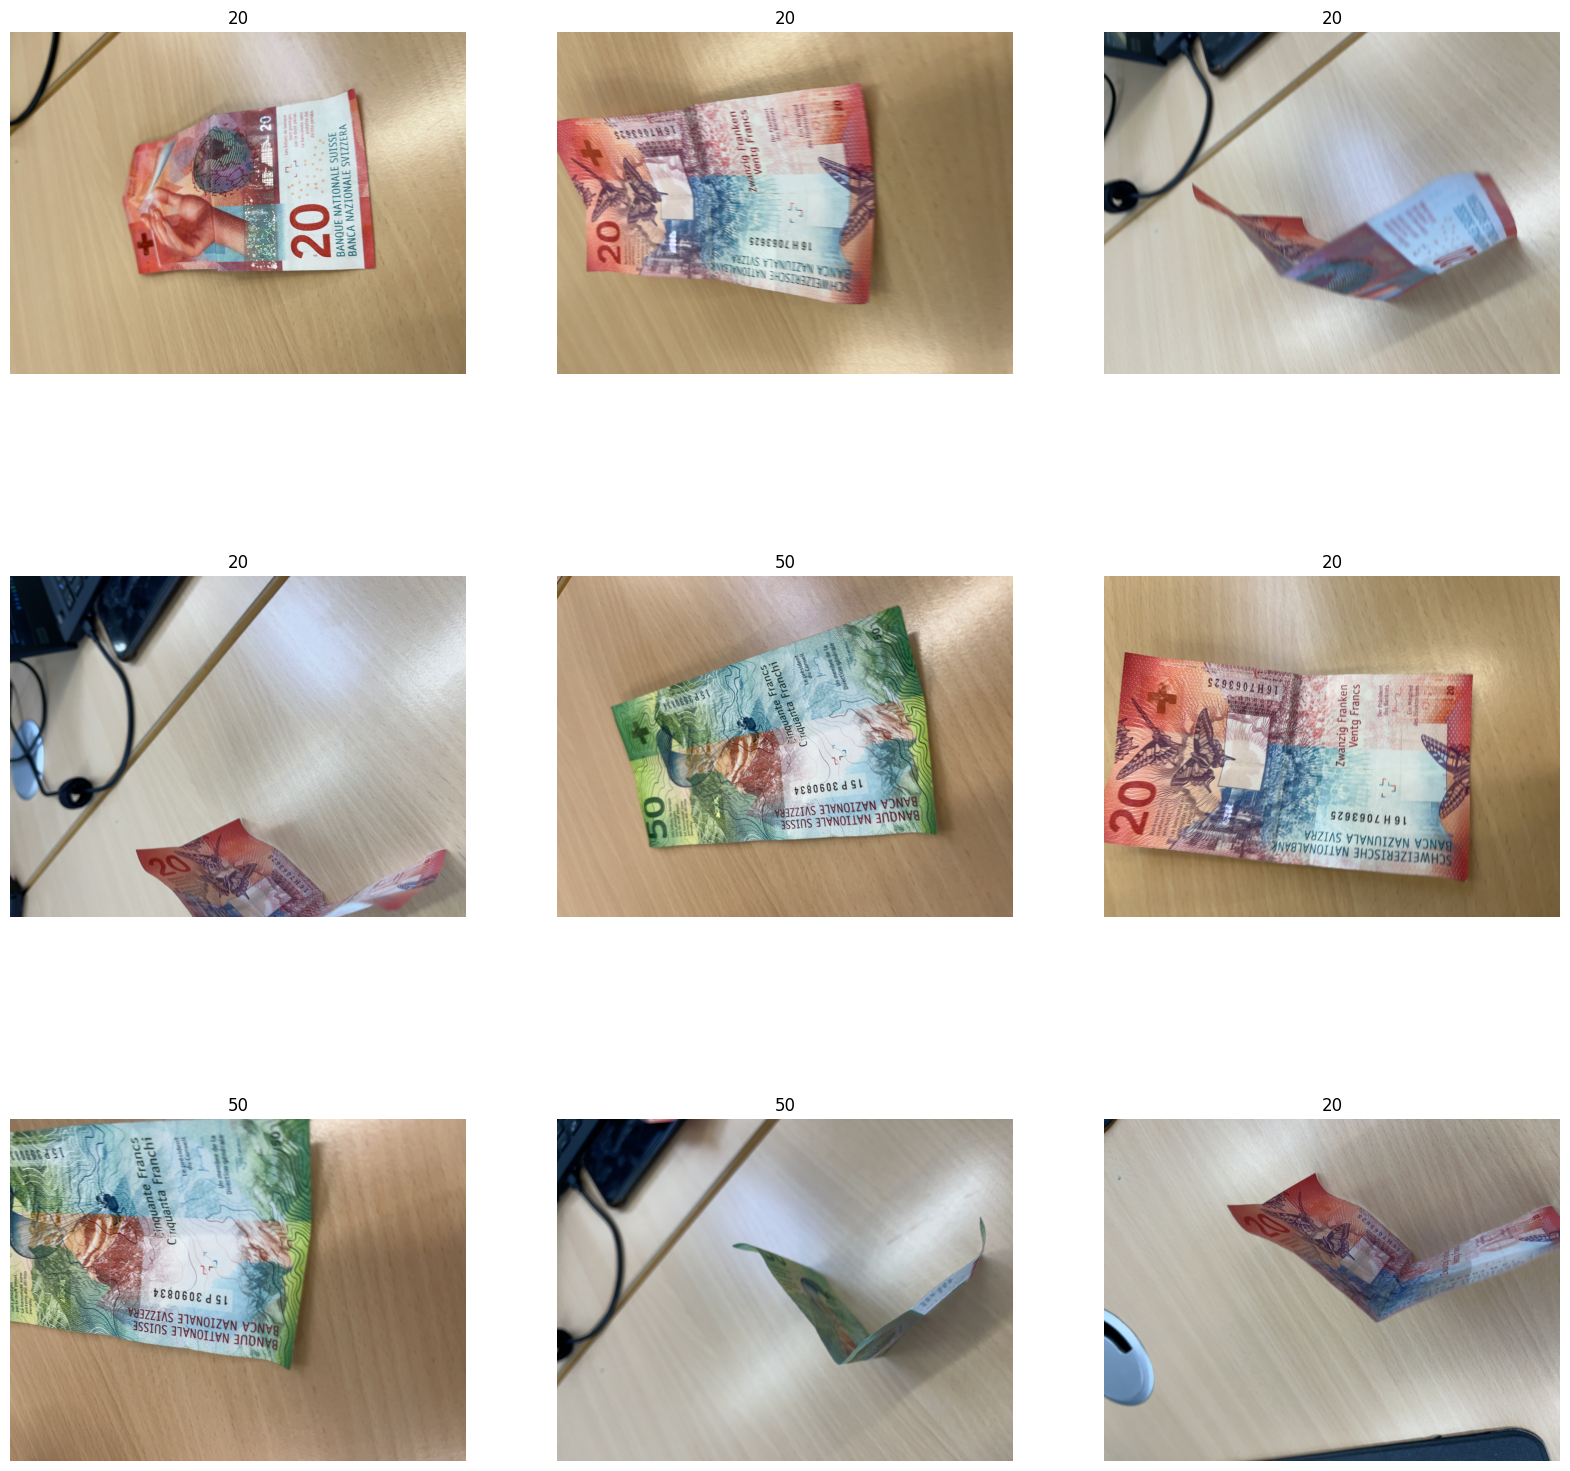

In [34]:
import matplotlib.pyplot as plt
import PIL
import PIL.Image
 
plt.figure(figsize=(20, 20))

i = 0
for _, rowdata in df.sample(frac=1).head(9).iterrows():
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(PIL.Image.open(rowdata.path))
    plt.title(rowdata.label)
    plt.axis("off")
    i += 1

# Explore your dataset

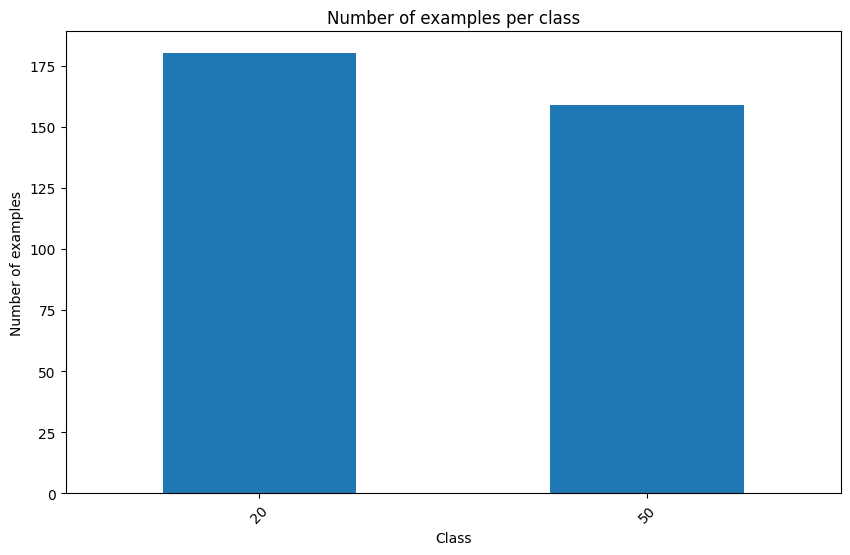

In [35]:
import matplotlib.pyplot as plt

# Count the number of examples per class
label_counts = df['label'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Number of examples per class')
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.xticks(rotation=45)
plt.show()


# Preprocessing steps

In [36]:
from tensorflow.keras.layers import (
    Resizing, Rescaling, RandomFlip, RandomRotation, RandomZoom
)
import tensorflow as tf

from tensorflow.keras import Sequential

IMG_HEIGHT = 224
IMG_WIDTH = 224

image_preprocesses = Sequential([
    Resizing(IMG_HEIGHT, IMG_WIDTH, crop_to_aspect_ratio=True),
    Rescaling(1. / 255)
])

image_augmentations = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    # TODO: choose some image augmentations layers
    # see which keras layers you can use
    # The kind of layers you will want to use starts with "Random".
    # See the following page for more information on data augmentation :
    # https://www.tensorflow.org/tutorials/images/data_augmentation
])

def open_images(paths):
    return np.stack([
        open_image(path) for path in paths
    ])

def open_image(path):
    with PIL.Image.open(path) as image:
        #opened_img = image_preprocesses(np.asarray(image))
        # Check the number of channels in the image
        if len(np.asarray(image).shape) == 2:  # Grayscale image
            # Duplicate the single channel to create a three-channel image
            image_rgb = np.stack((np.asarray(image),) * 3, axis=-1)
        else:  # Color image
            # Convert the image to RGB if it's not already in RGB mode
            if image.mode != "RGB":
                image = image.convert("RGB")
            # Convert the RGB image to array
            image_rgb = np.asarray(image)
        # Preprocess the image
        preprocessed_img = image_preprocesses(image_rgb)
        #print(preprocessed_img.shape)
    return preprocessed_img
    #return opened_img

def augment_images(images):
    return np.stack([
        image_augmentations(img) for img in images
    ])

In [37]:
import matplotlib.pyplot as plt
import numpy as np

original_images = open_images(df['path'])
original_labels = df['label']

preprocessed_images = open_images(df['path'])
augmented_images = augment_images(preprocessed_images)
# Replicate original labels for augmented images
augmented_labels = np.tile(original_labels, (len(image_augmentations.layers) + 1, 1)).flatten()[:len(augmented_images)]

all_img = np.concatenate((original_images, augmented_images), axis=0)
all_labels = np.concatenate((original_labels, augmented_labels), axis=0)


In [38]:
original_images.shape

(339, 224, 224, 3)

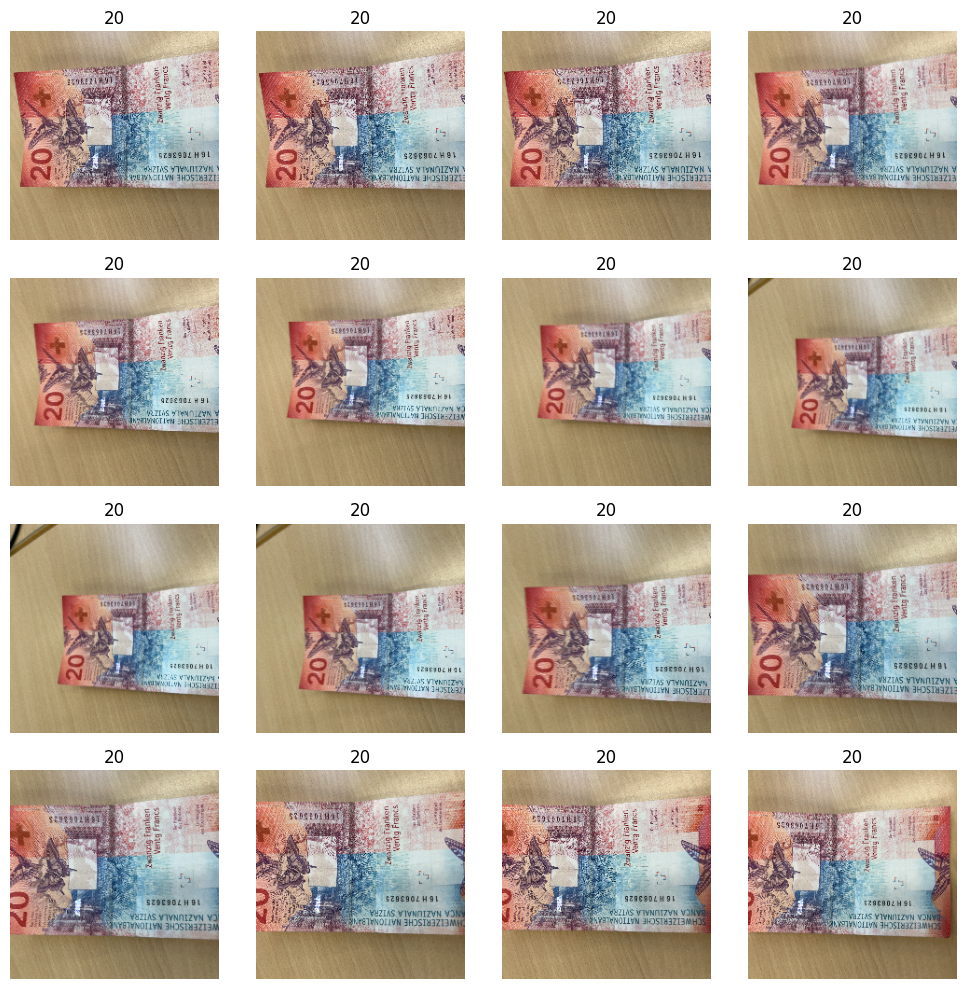

In [39]:

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

axes = axes.flatten()
for i in range(16):
    axes[i].imshow(augmented_images[i][0])
    axes[i].imshow(original_images[i])

    axes[i].set_title(all_labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

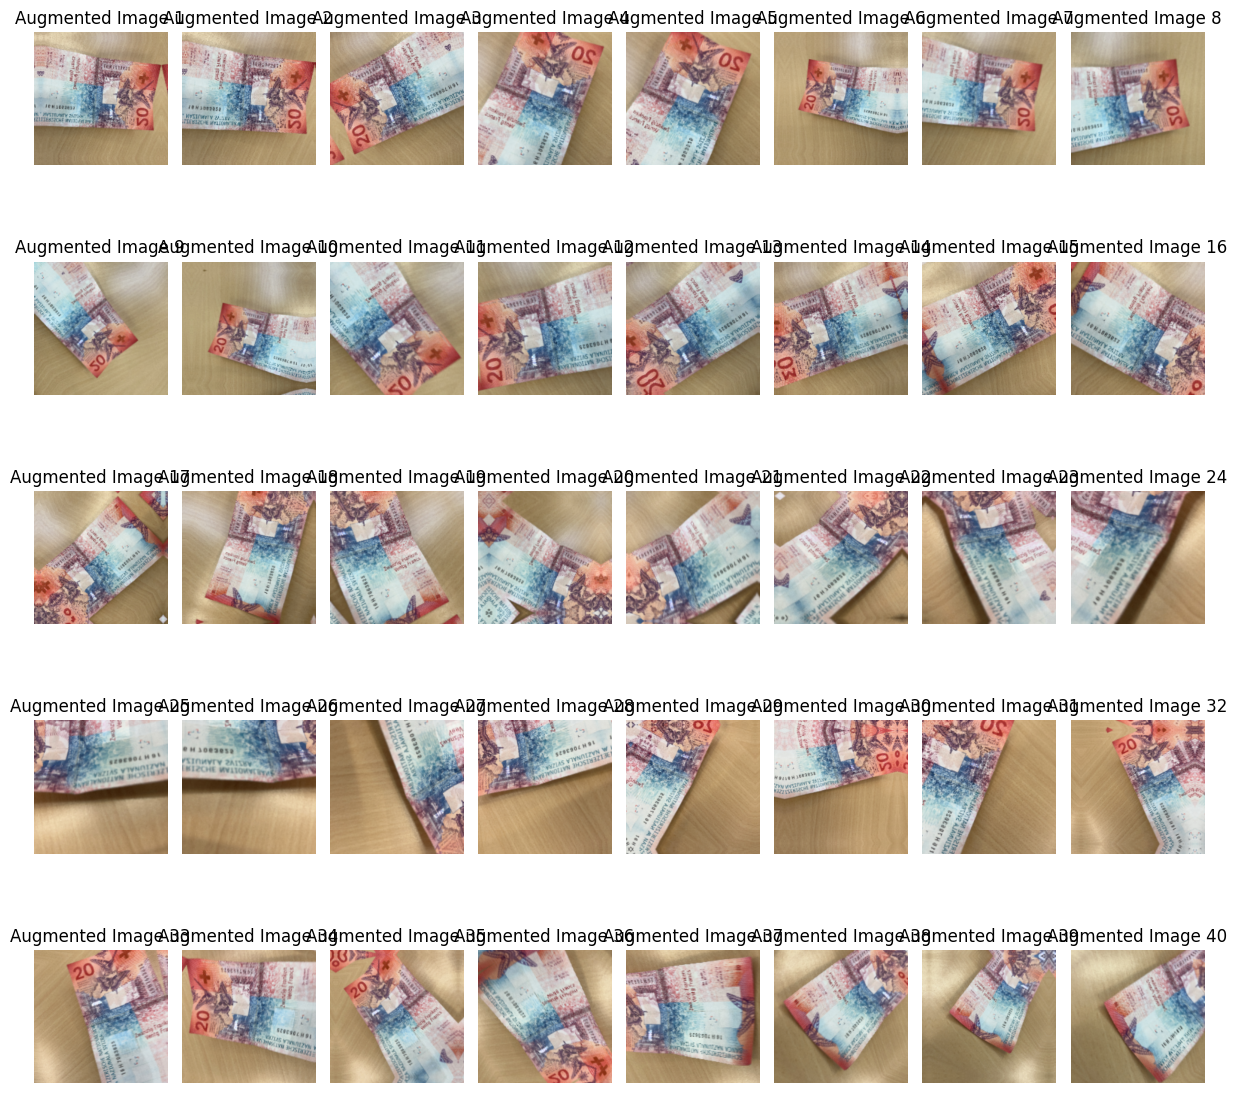

In [40]:

num_rows = 5
num_cols = 8
total_images = num_rows * num_cols

augmented_images_subset = augment_images(preprocessed_images, num_samples=total_images)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
axes = axes.flatten()
for i in range(total_images):
    axes[i].imshow(augmented_images_subset[i])
    axes[i].set_title(f"Augmented Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Define model

In [41]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    Dropout
)
NUM_CLASSES = len(QUERIES)
def get_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    )
    
    layers = base_model.output

    added_layers = [
        # important, we need global average pooling instead of flatten for class activation map later on 
        # Use GlobalAveragePooling2D instead of Flatten for class activation map later on
        GlobalAveragePooling2D(), 
        # Add a dense layer with 128 units and ReLU activation
        Dense(128, activation='relu'),
        # Add the final output layer with softmax activation for classification
        Dense(NUM_CLASSES, activation='softmax')]
        # TODO: ...
    

    model = Model(inputs=base_model.input, outputs=Sequential(added_layers)(layers))

    # TODO: freeze layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
      optimizer = RMSprop(),
      loss = SparseCategoricalCrossentropy(),
      metrics = ['acc']
    )
        
    return model

In [42]:
get_model().summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model training

**TODO**: cross-validate your model, you can base yourself on the code from the first part of this practical work

**NOTE**: you shouldn't augment validations images. What we want to evaluate is the performances on "real" images, not on images that are augmented and change all the time 

In [43]:
from sklearn.preprocessing import LabelEncoder

num_samples = len(all_labels)

# Create an array of shuffled indices
shuffled_indices = np.arange(num_samples)
np.random.shuffle(shuffled_indices)

# Shuffle the images and labels using the shuffled indices
totalset = all_img[shuffled_indices]
labels = all_labels[shuffled_indices]

# transform labels in integer
label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)


In [44]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

NB_EPOCHS = 4

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for train_idx, test_idx in KFold(n_splits=3).split(totalset, labels):
    
    model = get_model() # We reinitialize the model
    
    history = model.fit(
        x=totalset[train_idx],
        y=labels[train_idx],
        batch_size=32,
        validation_data=[totalset[test_idx], labels[test_idx]],
        epochs=NB_EPOCHS,
        verbose=True
    )
    
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])
    train_accuracies.append(history.history['acc'])
    val_accuracies.append(history.history['val_acc'])

Epoch 1/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - acc: 0.6262 - loss: 1.3105 - val_acc: 0.8894 - val_loss: 0.2799
Epoch 2/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 988ms/step - acc: 0.8846 - loss: 0.2459 - val_acc: 0.8451 - val_loss: 0.3067
Epoch 3/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9700 - loss: 0.1194 - val_acc: 0.9912 - val_loss: 0.0718
Epoch 4/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.9740 - loss: 0.0826 - val_acc: 0.9956 - val_loss: 0.0520
Epoch 1/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - acc: 0.6088 - loss: 1.2086 - val_acc: 0.9336 - val_loss: 0.2281
Epoch 2/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - acc: 0.9300 - loss: 0.1985 - val_acc: 0.7345 - val_loss: 0.4939
Epoch 3/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 992ms/step - acc: 0.8919 - loss: 0.2344 - val_acc: 0.9779 - val_loss: 0.0688
Epoch 4/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - acc: 0.9743 - loss: 0.0855 - val_acc: 0.9867 - val_loss: 0.0579
Epoch 1/4
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - acc: 0.6422 - loss: 1.2

In [50]:
def plot_kfold_mean_performance(ax, train_performances, val_performances, measure_name):
    train_mean = np.mean(train_performances, axis=0)
    val_mean = np.mean(val_performances, axis=0)
    train_sd = np.std(train_performances, axis=0)
    val_sd = np.std(val_performances, axis=0)
    
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean+train_sd, facecolor='blue', alpha=0.5, label='Train')
    ax.fill_between(np.arange(NB_EPOCHS), train_mean, train_mean-train_sd, facecolor='blue', alpha=0.5)

    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean+val_sd, facecolor='orange', alpha=0.5, label='Val')
    ax.fill_between(np.arange(NB_EPOCHS), val_mean, val_mean-val_sd, facecolor='orange', alpha=0.5)

    ax.set_xticks(np.arange(NB_EPOCHS))

    ax.set_ylabel(measure_name)
    ax.set_xlabel('Number of epochs')
    #pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    ax.legend()
    ax.grid()


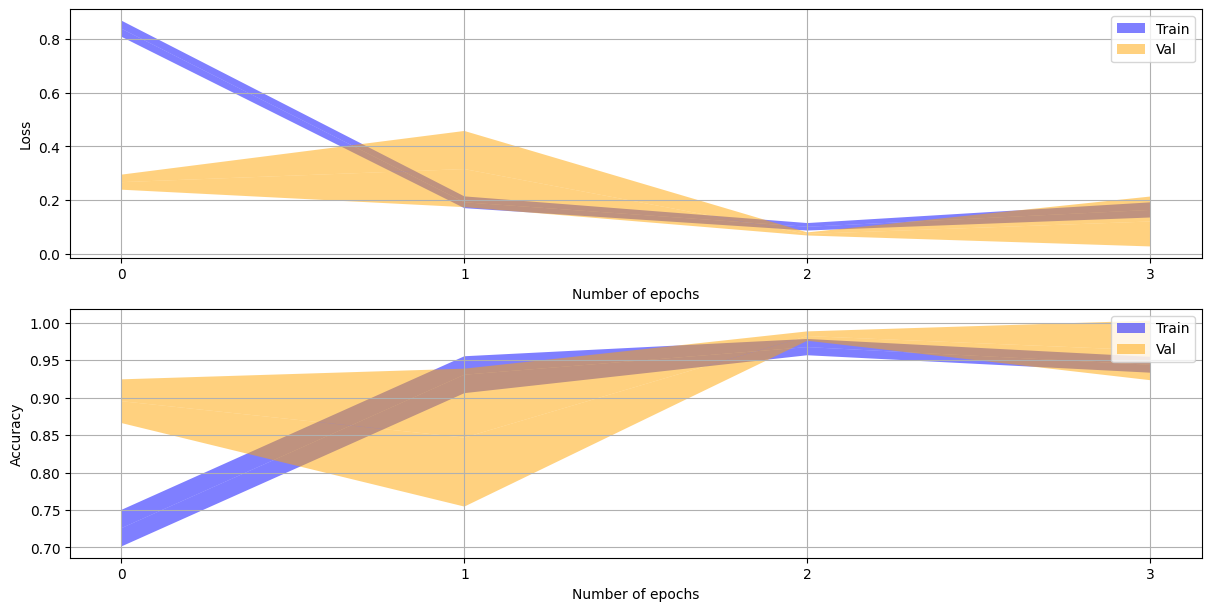

In [51]:
import matplotlib.pyplot as pl

fig, axs = plt.subplots(2, 1, constrained_layout=True, figsize=(12,6))

plot_kfold_mean_performance(axs[0], train_losses, val_losses, "Loss")
plot_kfold_mean_performance(axs[1], train_accuracies, val_accuracies, "Accuracy")

In [ ]:

totalset = open_images(df['path'])
labels = df['label']


In [53]:

label_encoder = LabelEncoder()
label_encoder.fit(labels)
labels = label_encoder.transform(labels)


## Evaluation du modèle

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 669ms/step - acc: 0.6296 - loss: 0.8987
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step  


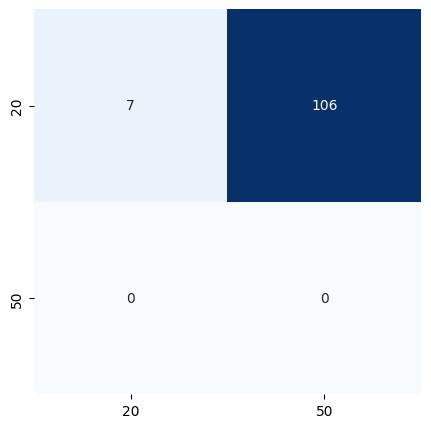

F1 Score - Fold 1: 0.062
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 675ms/step - acc: 0.6251 - loss: 0.9658
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 706ms/step


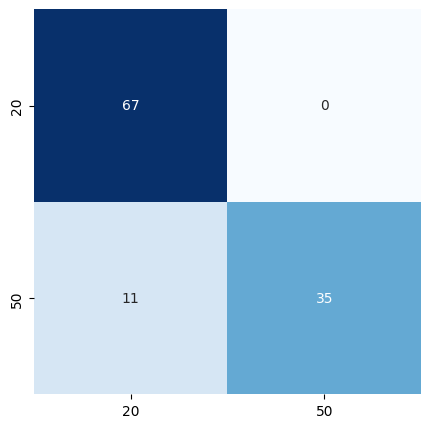

F1 Score - Fold 2: 0.903
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step - acc: 0.9508 - loss: 0.1771
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 729ms/step


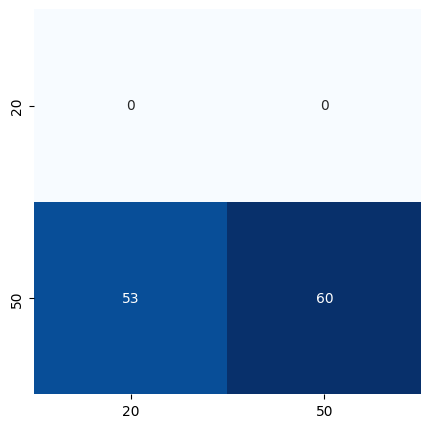

F1 Score - Fold 3: 0.531
Mean F1 Score across all folds: 0.499


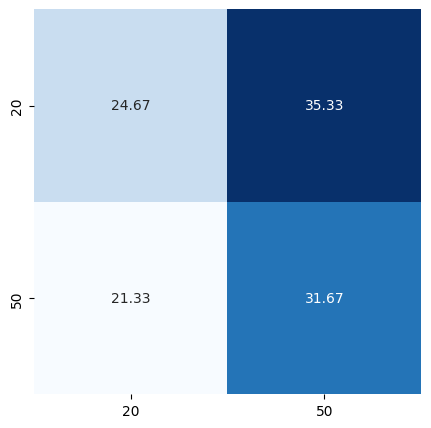

In [58]:
import numpy as np
import sklearn.metrics as me
import seaborn as sns
import matplotlib.pyplot as pl
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

QUERIES = ["20", "50"]
labels = np.array(labels)

f1_scores = []
mean_confusion_matrix = np.zeros((len(QUERIES), len(QUERIES)))
model = get_model()
i = 1

for train_idx, test_idx in KFold(n_splits=3).split(totalset, labels):

    model.fit(totalset[train_idx], labels[train_idx])
    predicted_probabilities = model.predict(totalset[test_idx])
    predictions = np.argmax(predicted_probabilities, axis=1)
    true_labels = labels[test_idx]
    
    cm = confusion_matrix(true_labels, predictions, labels=np.arange(len(QUERIES)))
    mean_confusion_matrix += cm
    
    pl.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=QUERIES, yticklabels=QUERIES)
    pl.show()
    
    f1 = me.f1_score(true_labels, predictions, average='micro')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i}: {f1:.3f}")
    i += 1

mean_f1_score = np.mean(f1_scores)
mean_confusion_matrix /= 3
print(f"Mean F1 Score across all folds: {mean_f1_score:.3f}")

pl.figure(figsize=(5, 5))
sns.heatmap(mean_confusion_matrix, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=QUERIES, yticklabels=QUERIES)
pl.show()


# Results

**TODO**: plot the results from your crossvalidation

## Evaluate model on test set

**TODO**: when you've selected a final model, evaluate its performances (f-score, confusion matrix, ...) on your test set

### Display some misclassified images

**TODO**: display some misclassified images to be able to see what images are difficult for the model

## Use grad-cam to inspect how the model classify
Here we can see an heatmap of the regions that activates the model the most.

### For more information:
- tf-keras-vis documentation: https://keisen.github.io/tf-keras-vis-docs/
- Grad-cam paper: https://arxiv.org/pdf/1610.02391.pdf
- Grad-cam++ paper: https://arxiv.org/pdf/1710.11063.pdf

**NOTE**: maybe you will need to adapt some variable names based on your code above. For example, _model_ should be the model trained on all the training data. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tensorflow.keras.applications import MobileNetV2
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create GradCAM++ object
gradcam = GradcamPlusPlus(
    model,
    model_modifier=ReplaceToLinear(),
    clone=True,
)

nb_images_per_class = 100

fig, axs = plt.subplots(nb_images_per_class, len(LABEL_NAMES), figsize=(len(LABEL_NAMES) * 5, nb_images_per_class * 5))

for label_idx, label_name in enumerate(LABEL_NAMES):
    axs[0,label_idx].set_title(label_name, loc='center', y=1.1)
    
    i = 0
    for _, rowdata in df[df['label'] == label_name].sample(frac=1).head(nb_images_per_class).iterrows():
        img = open_image(rowdata.path)    
        pred = model(np.expand_dims(img, axis=0))

        # Generate cam with GradCAM++
        score = CategoricalScore(np.argmax(pred))
        cam = gradcam(score, img)
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

        axs[i,label_idx].imshow(img, vmin=0, vmax=1)
        axs[i,label_idx].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
        axs[i,label_idx].axis("off")

        i += 1

### Grad-cam on misclassified images

**TODO**: now do the same than above, but with the misclassified images. You shouldn't change anything pertaining to grad-cam besides on which image and prediction you do it

**TODO**: try to determine what caused the misclassifcations and what you can do about it